In [33]:
# Import libraries
import numpy as np
import pandas as pd
import string
import matplotlib.pyplot as plt
import spacy
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
import scipy
from wordcloud import WordCloud, STOPWORDS
from joblib import dump, load
import torch
import torch.nn as nn
from transformers import BertModel, BertTokenizer, DistilBertTokenizer, DistilBertModel
from eli5.lime import TextExplainer
from eli5.lime.samplers import MaskingTextSampler
import shap
shap.initjs()
nlp = spacy.load('en_core_web_sm')

def text_cleaning(text):
    text = nlp(text)
    text = ' '.join([token.text for token in text if token.ent_type_ not in ["PERSON", "DATE"]])
    return text.replace("REDACTED", "").lower().replace("[Name]", "").replace("[your name]", "").\
                            replace("dear admissions committee,", "").replace("sincerely,","").\
                            replace("[university's name]","fordham").replace("dear sir/madam,","").\
                            replace("– statement of intent  ","").\
                            replace('program: master of science in data analytics  name of applicant:    ',"").\
                            replace("data analytics", "data science").replace("| \u200b","").\
                            replace("m.s. in data science at lincoln center  ","").\
                            translate(str.maketrans('', '', string.punctuation)).strip().lstrip()

test_text_Human = """Dominicans constantly dream of having a country that is social, economic, and politically sustainable. As an active citizen of my nation, I believe that this goal is obtainable. The most vital source governments use to provide public services is taxation. In my current position as a Data Scientist at the General Directorate of Internal Taxes (DGII), I would like to be an agent of change to aid in helping my people access better quality public services.
Having a major in Business Engineering and applying statistical and computational knowledge to enhance my labor has led me to increase my interest in further research in Data Science. Specifically, I aspire to pursue a program with a holistic perspective in algorithms, statistics, and mathematics. I believe Fordham’s M.S. in Data Science combines the knowledge of manipulating large data datasets, building advanced computational models alongside Financial Informatics to contribute to the development of the Dominican Republic as a public employee for the taxation service.
As for accomplishments: Being awarded the INTEC Meritorious Scholarship awarded to the top 1%, Summa Cum Laude bachelor's degree, and elected Vice-President of the Business Engineering Students Committee in 2016. Additionally, I served as a teaching assistant for Linear Algebra. My first professional experience was in INABIMA (the Pension Fund of the Ministry of Education) during my senior year, where I worked on various projects related to risk management and statistical indicators in conjunction with the United Nations Development Programme.
In September 2018, I joined DGII. There, I worked in the development of projects such as new Registry Digital Forms and the machine learning engine that sets what taxes taxpayers must pay according to their form of business and behavior. For most of the preprocessing and data wrangling, I designed Python data pipelines. Also, I created and implemented validations with SQL triggers, stored procedures, and worked on data analysis and visualizations for data-driven decisions.
In April 2020, I became part of the Research and Analytics Office as a Data Scientist. As part of my job, I extract data from SQL databases, perform data analysis, visualizations, and machine learning models with Python, R, and Power Bi. These new Artificial Intelligence models facilitate the selection process of tax audit cases based on taxpayers' behavior profiles, supporting better decision making.
Once I achieve my graduate studies, I will return to my duties at the General Directorate of Internal Taxes, where I plan to use my knowledge to reduce tax evasion and prevent tax non-compliance. To improve the current machine learning that our Tax Administration uses, I will implement new Deep Learning architectures in addition to Big Data programming.
Being aware of the importance of labor as a factor of production (economically speaking) and, as part of my contribution to its development, I want to contribute to the education of Dominican professionals, sharing my knowledge as a teacher and as a researcher after getting my master's. This will continue and improve the labor I have made being a teaching assistant during my college years."""

test_text_AI = """During my undergraduate studies, I gained a solid foundation in programming languages such as Python and R, as well as experience working with SQL databases. I also had the opportunity to apply these skills in a real-world setting during an internship as a data analyst at a healthcare company. In this role, I was responsible for collecting, cleaning, and analyzing large datasets to provide insights into patient outcomes and healthcare costs.
Through the Master's in Data Science program at Fordham University, I aim to further develop my expertise in data science and analytics, with a focus on machine learning and predictive modeling. I am particularly interested in courses that cover topics such as deep learning, natural language processing, and data visualization. I am confident that this program will provide me with the skills and knowledge necessary to make valuable contributions to the field of data science.
Furthermore, I am impressed with the collaborative and interdisciplinary nature of the program, and I am excited about the opportunity to work with fellow students and faculty members from diverse backgrounds and fields. I am also attracted to the program's emphasis on practical, hands-on learning, which I believe will prepare me well for a career in data science.
Thank you for considering my application. I am excited about the prospect of joining the Fordham University community and contributing to the vibrant academic and research environment of the Master's in Data Science program.
Sincerely,"""

test_text_mixed_Human_AI = """Though I was barely exposed to programming while doing my B.A. in Economics, my eagerness to face new challenges led me to learn many computer languages like R and SQL. Ultimately, I decided to pursue a master's in Data Science at Fordham University, where I am fortunate to hold a Graduate Assistant position in Fordham's Computer and Information Sciences (CIS) department. Some projects have exposed me to the undertakings of high-level research and the massive amount of objectives and tasks necessary to transform a research proposal into a ranked article publication. But, most importantly, I have comprehended the role researchers play in advancing the computer science field and the gratification that yields, having contributed to it. As a result, I am driven to pursue a Ph.D. in Computer Science at NYU Tandon School of Engineering to broaden my knowledge and become an established researcher.
In addition to my academic pursuits, I have also gained valuable experience through internships and extracurricular activities. During my undergraduate years, I interned at a non-profit organization where I assisted in developing a database management system. This experience allowed me to apply my programming skills in a real-world setting and reinforced my interest in pursuing a career in technology.
Furthermore, I have been an active member of the Computer Science Club, where I have participated in various coding competitions and hackathons. These experiences have not only honed my technical skills but also taught me the importance of teamwork and collaboration in solving complex problems. I have also volunteered as a tutor, helping students with programming and data analysis. This experience has allowed me to share my knowledge with others and has reinforced my desire to pursue a career in academia.
As I embark on the next stage of my academic journey, I am eager to continue building on my experiences and knowledge. I am confident that pursuing a Ph.D. in Computer Science at NYU Tandon School of Engineering will provide me with the tools and resources necessary to achieve my academic and professional goals. I look forward to contributing to the vibrant research community at NYU and making meaningful contributions to the field of Computer Science."""

In [12]:
# Read data
df_HumanGenerated = pd.read_csv("/kaggle/input/capstoneresearchds/df_real_better.csv", dtype=str)
df_AIGeneratedSOI = pd.read_csv("/kaggle/input/capstoneresearchds/GeneratedSOIs.csv", dtype=str)
df_AIGeneratedLOR = pd.read_csv("/kaggle/input/capstoneresearchds/Generated_LORs.csv", dtype=str)

# Label data: {Human:0, AI: 1}
df_HumanGenerated["Target"] = 0; df_AIGeneratedSOI["Target"] = 1; df_AIGeneratedLOR["Target"] = 1
df_AIGeneratedSOI.rename({df_AIGeneratedSOI.columns[0]: "ID", df_AIGeneratedSOI.columns[2]: "Text"},axis=1, inplace=True)
df_AIGeneratedSOI["ID"] = df_AIGeneratedSOI.ID.map(lambda x: "0"+str(x))
df_AIGeneratedLOR.rename({df_AIGeneratedLOR.columns[0]: "Text"},axis=1, inplace=True)

# Get only relevant attributes from the original datasources
cols = ["ID", "Text", "Target"]
df_HumanGenerated = df_HumanGenerated[cols]#df_HumanGenerated = df_HumanGenerated[df_HumanGenerated.ID.isin(df_AIGeneratedSOI["ID"].values)][cols]
df_AIGeneratedSOI = df_AIGeneratedSOI[cols]

# Union both human-written and AI generated datasets
df = pd.concat([df_HumanGenerated.dropna(axis=0), df_AIGeneratedSOI])[["Text", "Target"]]
df = pd.concat([df, df_AIGeneratedLOR])
df.reset_index(drop=True, inplace=True)

df = df.sample(len(df))

# Feature engineering - For further modeling experiment
def AvgSentence(text):
    plist = text.split("\n")
    return np.mean([p.count(".") for p in plist])

df["CountParagraphs"] = df.Text.map(lambda x: x.count("\n"))
df["SumSentences"] = df.Text.map(lambda x: x.count(". "))
df["AvgSentenceByParagraphs"] = df.Text.map(AvgSentence)

# Preprocessing for modelling + more cleaning

df["Text"] = df["Text"].map(lambda x: text_cleaning(x))
df = df.drop_duplicates()

In [17]:
# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(df.drop("Target",axis=1), df.Target, train_size=0.80)
train_sentences = X_train.Text.to_list(); test_sentences = X_test.Text.to_list()

# Text Analysis

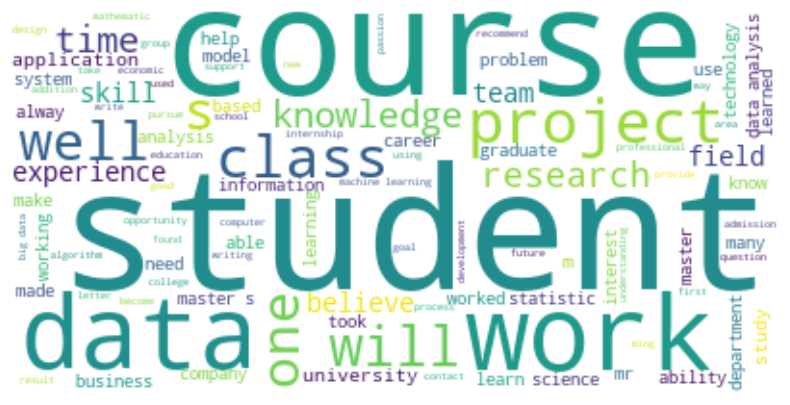

In [ ]:
# Wordcloud Analysis for Human Targeted Texts
stopwords = set(STOPWORDS)
words_to_ignore = [r'(?i)fordham university',r"(?i)data science",r"(?i)computer science", r"(?i)msds", r"(?i)program"]
df_human_wordcloud = ' '.join(df[df["Target"] == 0].Text.replace(words_to_ignore,"",regex=True))
wordcloud = WordCloud(stopwords=stopwords, background_color="white", max_words=100).generate(df_human_wordcloud)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [ ]:
df[(df["Target"] == 0) & (df["CountParagraphs"] > 0)].drop("Target",axis=1).describe()

,CountParagraphs,SumSentences,AvgSentenceByParagraphs
count,5149.000000,5149.000000,5149.000000
mean,3.695669,14.766362,4.514998
std,2.570457,7.844818,1.961584
min,1.000000,0.000000,0.750000
25%,2.000000,9.000000,3.250000
50%,3.000000,14.000000,4.200000
75%,5.000000,18.000000,5.400000
max,87.000000,97.000000,27.500000


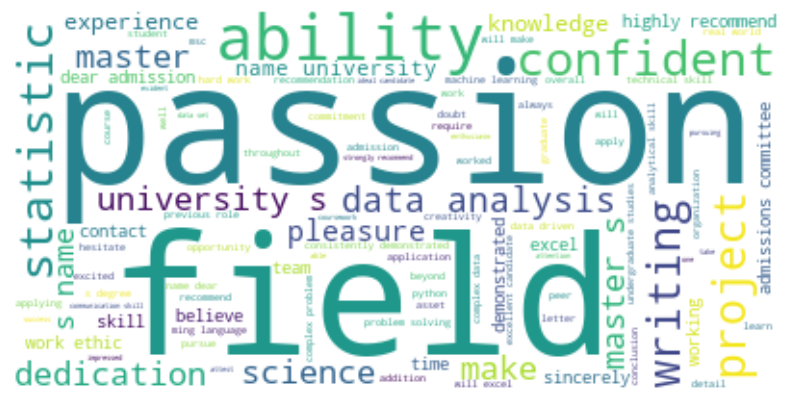

In [ ]:
# Wordcloud Analysis for AI Targeted Texts
df_human_wordcloud = ' '.join(df[df["Target"] == 1].Text.replace(words_to_ignore,"",regex=True))
wordcloud = WordCloud(stopwords=stopwords, background_color="white", max_words=100).generate(df_human_wordcloud)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [ ]:
df[(df["Target"] == 1) & (df["CountParagraphs"] > 0)].drop("Target",axis=1).describe()

,CountParagraphs,SumSentences,AvgSentenceByParagraphs
count,4644.000000,4644.000000,4644.000000
mean,7.110250,8.302326,1.716685
std,1.835324,3.024615,0.513140
min,2.000000,2.000000,0.692308
25%,6.000000,6.000000,1.375000
50%,7.000000,8.000000,1.571429
75%,8.000000,9.000000,1.888889
max,17.000000,30.000000,5.142857


# Baseline Models (Naive Bayes & Logistic Regression)

In [18]:
## Logistic Regression + TF-IDF Pipeline
model_0_lr = Pipeline([
                    ("tf-idf", TfidfVectorizer()),
                    ("clf", LogisticRegression())
])
model_0_lr.fit(X=train_sentences,
               y=y_train)

## Naive Bayes + TF-IDF Pipeline
model_0_nb = Pipeline([
                    ("tf-idf", TfidfVectorizer()),
                    ("clf", MultinomialNB())
])
model_0_nb.fit(X=train_sentences,
               y=y_train)

print(f"TF-IDF + LR")
print(f"Accuracy: {model_0_lr.score(test_sentences, y_test)}\n")
print(classification_report(y_test, model_0_lr.predict(test_sentences)),"\n")

print(f"TF-IDF + NB")
print(f"Accuracy: {model_0_nb.score(test_sentences, y_test)}\n")
print(classification_report(y_test, model_0_nb.predict(test_sentences)))

# Save baseline models
# dump(model_0_lr, "baseline_model_lr.joblib");
# dump(model_0_nb, "baseline_model_nb.joblib");

TF-IDF + LR
Accuracy: 0.9970588235294118

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1115
           1       1.00      0.99      1.00       925

    accuracy                           1.00      2040
   macro avg       1.00      1.00      1.00      2040
weighted avg       1.00      1.00      1.00      2040
 

TF-IDF + NB
Accuracy: 0.9975490196078431

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1115
           1       1.00      1.00      1.00       925

    accuracy                           1.00      2040
   macro avg       1.00      1.00      1.00      2040
weighted avg       1.00      1.00      1.00      2040



In [ ]:
# Load baseline model to test it with untested data 
model_X = joblib.load("baseline_model_lr2.joblib")
pred_value = model_X.predict([test_text_mixed_Human_AI])
round(model_X.predict_proba([test_text_mixed_Human_AI]).squeeze()[pred_value].item(),4)

0.7188

### Model explanation example using LIME

In [ ]:
explainer = TextExplainer(sampler=MaskingTextSampler())
explainer.fit(test_sentences[4],model_0_lr.predict_proba)
explainer.show_prediction(target_names=["Human", "AI"])

TextExplainer(char_based=False,
              clf=SGDClassifier(alpha=0.001, loss='log', penalty='elasticnet',
                                random_state=RandomState(MT19937) at 0x7E542A51D6B0),
              sampler=MaskingTextSampler(token_pattern='(?u)\\b\\w+\\b'),
              token_pattern='(?u)\\b\\w+\\b',
              vec=CountVectorizer(ngram_range=(1, 2),
                                  token_pattern='(?u)\\b\\w+\\b'))

In [ ]:
explainer.explain_prediction(target_names=["Human", "AI"])

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.


Explanation(estimator="SGDClassifier(alpha=0.001, loss='log', penalty='elasticnet',\n              random_state=RandomState(MT19937) at 0x7E53409C56B0)", description=None, error=None, method='linear model', is_regression=False, targets=[TargetExplanation(target='Human', feature_weights=FeatureWeights(pos=[FeatureWeight(feature='she', weight=0.8871877807524362, std=None, value=6.0), FeatureWeight(feature='<BIAS>', weight=0.7281586080324352, std=None, value=1.0), FeatureWeight(feature='ms', weight=0.5057652362397779, std=None, value=2.0), FeatureWeight(feature='course', weight=0.4630032629306912, std=None, value=4.0), FeatureWeight(feature='is', weight=0.42495053530085636, std=None, value=6.0), FeatureWeight(feature='visa', weight=0.34423412988358537, std=None, value=3.0), FeatureWeight(feature='the', weight=0.31805933035715855, std=None, value=4.0), FeatureWeight(feature='analytics', weight=0.29478162809406006, std=None, value=2.0), FeatureWeight(feature='students', weight=0.2815174541707158, std=None, value=2.0), FeatureWeight(feature='was', weight=0.26268060859861925, std=None, value=4.0), FeatureWeight(feature='test', weight=0.21677125295735838, std=None, value=3.0), FeatureWeight(feature='scores', weight=0.18400617023060484, std=None, value=2.0), FeatureWeight(feature='my', weight=0.1828917534035306, std=None, value=2.0), FeatureWeight(feature='on', weight=0.16114341859750272, std=None, value=3.0), FeatureWeight(feature='able', weight=0.1571835458011264, std=None, value=4.0), FeatureWeight(feature='her data', weight=0.15375697970420285, std=None, value=2.0), FeatureWeight(feature='of', weight=0.15128428706751923, std=None, value=3.0), FeatureWeight(feature='factors', weight=0.1499353475978889, std=None, value=2.0), FeatureWeight(feature='met', weight=0.12416361757606449, std=None, value=1.0), FeatureWeight(feature='in data', weight=0.12365737775021422, std=None, value=2.0), FeatureWeight(feature='class', weight=0.11327947703142995, std=None, value=1.0), FeatureWeight(feature='other', weight=0.11028245856611378, std=None, value=1.0), FeatureWeight(feature='a', weight=0.10467595936789341, std=None, value=4.0), FeatureWeight(feature='appropriately', weight=0.10448603462912179, std=None, value=1.0), FeatureWeight(feature='as', weight=0.10155740165194521, std=None, value=1.0), FeatureWeight(feature='enrolled', weight=0.10057701305865337, std=None, value=1.0), FeatureWeight(feature='questions about', weight=0.10026342018044673, std=None, value=1.0), FeatureWeight(feature='through', weight=0.09969947941612738, std=None, value=2.0), FeatureWeight(feature='when', weight=0.09858235523409725, std=None, value=1.0), FeatureWeight(feature='both', weight=0.09708076347432214, std=None, value=1.0), FeatureWeight(feature='topics', weight=0.09578810651311102, std=None, value=1.0), FeatureWeight(feature='about', weight=0.09519568393435313, std=None, value=5.0), FeatureWeight(feature='so', weight=0.090412409019174, std=None, value=1.0), FeatureWeight(feature='scores and', weight=0.09006518276003575, std=None, value=1.0), FeatureWeight(feature='analytic', weight=0.08559058560238243, std=None, value=1.0), FeatureWeight(feature='answer', weight=0.0846260560884762, std=None, value=1.0), FeatureWeight(feature='disciplined', weight=0.08429352043748607, std=None, value=1.0), FeatureWeight(feature='fast', weight=0.075949434680531, std=None, value=1.0), FeatureWeight(feature='future', weight=0.06893342133452436, std=None, value=1.0), FeatureWeight(feature='is with', weight=0.0645767855816735, std=None, value=1.0), FeatureWeight(feature='applications was', weight=0.06384158958783069, std=None, value=1.0), FeatureWeight(feature='it', weight=0.06348879788249949, std=None, value=2.0), FeatureWeight(feature='work of', weight=0.06321769771752822, std=None, value=1.0), FeatureWeight(feature='questions', weight=0.05931286383579108, std=None, value=2.0), FeatureWeight(feature='analysis process', weight=0.05876807189685468, std=None, value=1.0), FeatureWeight(fea

# Transformer-based Models

##-Bert based model

In [10]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Encode the text data
train_encodings = tokenizer(train_sentences, truncation=True, padding=True)
val_encodings = tokenizer(test_sentences, truncation=True, padding=True)

# Include additional features
columns = X_train.drop(["Text"],axis=1).columns.to_list()

for column in columns:
    train_encodings[column] = X_train[column].to_list()
    val_encodings[column] = X_test[column].to_list()

In [11]:
from torch.utils.data import Dataset, DataLoader

class TextDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)


train_dataset = TextDataset(train_encodings, y_train.values)
val_dataset = TextDataset(val_encodings, y_test.values)

batch_size = 8

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [12]:
from typing import Optional
class TransformerBasedModelBert(nn.Module):
    def __init__(self):
        super(TransformerBasedModelBert, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.dropout = nn.Dropout(0.55)
        self.fc = nn.Linear(768, 2)

    def forward(self, input_ids: torch.Tensor, attention_mask: Optional[torch.Tensor] = None):
        input_shape = input_ids.size()
        if attention_mask is None:
            attention_mask = torch.ones(input_shape, device=device)
            
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs[1]
        pooled_output = self.dropout(pooled_output)
        logits = self.fc(pooled_output)
        return logits

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = TransformerBasedModelBert().to(device)
print(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


cuda


### Model Training and Testing

In [13]:
class EarlyStopping:
    def __init__(self, patience=2, delta=0.0001):
        self.patience = patience
        self.counter = 0
        self.best_score = None
        self.delta = delta

    def __call__(self, val_loss, model):
        score = val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score > self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                return True
        else:
            self.save_checkpoint(val_loss, model)
            self.best_score = score
            self.counter = 0
        return False

    def save_checkpoint(self, val_loss, model):
        torch.save(model.state_dict(), 'checkpoint.pt')
        print(f'Validation loss decreased ({self.best_score:.6f} --> {val_loss:.6f}). Saving model ...')


optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
loss_fn = nn.CrossEntropyLoss()
early_stopping = EarlyStopping()

num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    train_total = 0
    for batch in train_loader:
      input_ids = batch['input_ids'].to(device)
      attention_mask = batch['attention_mask'].to(device)
      labels = batch['labels'].to(device)
      logits = model(input_ids=input_ids, attention_mask=attention_mask)
      loss = loss_fn(logits, labels)

      train_loss += loss
      train_total += labels.size(0)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

    model.eval()
    with torch.inference_mode():
        correct = 0
        test_loss = 0
        total = 0
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            logits = model(input_ids=input_ids, attention_mask=attention_mask)
            test_loss += loss_fn(logits, labels)
            _, predicted = torch.max(logits, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
    early_stop = early_stopping(test_loss/total, model)
    
    if early_stop:
        print("Early stopping")
        break


    print(f'Epoch {epoch+1} out of {num_epochs} | Train Loss: {train_loss/train_total:.6f} | Test Accuracy: {correct/total:.6f}')

Validation loss decreased (0.000489 --> 0.000489). Saving model ...
Epoch 1 out of 5 | Train Loss: 0.003928 | Test Accuracy: 0.998529
EarlyStopping counter: 1 out of 2
Epoch 2 out of 5 | Train Loss: 0.000323 | Test Accuracy: 0.998529
EarlyStopping counter: 2 out of 2
Early stopping


In [26]:
def nn_pred(model, text):
    cleaned_text = text_cleaning(text)
    cleaned_text_tokens = tokenizer([cleaned_text], truncation=True, padding=True)
    with torch.inference_mode():
        input_ids, att = cleaned_text_tokens["input_ids"], cleaned_text_tokens["attention_mask"]
        input_ids = torch.tensor(input_ids).to(device)
        attention_mask = torch.tensor(att).to(device)
        logits = model(input_ids=input_ids, attention_mask=attention_mask)
        _, predicted = torch.max(logits, 1)
        return predicted.item()

print(f"{'AI' if nn_pred(model, test_text_Human) == 1 else 'Human'}")
print(f"{'AI' if nn_pred(model, test_text_AI) == 1 else 'Human'}")
print(f"{'AI' if nn_pred(model, test_text_mixed_Human_AI) == 1 else 'Human'}")

Human
AI
AI


In [49]:
model.eval()  # Set the model to evaluation mode

true_labels = []
predicted_labels = []


    # Move inputs and labels to the appropriate device (GPU or CPU)
for batch in val_loader:
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    labels = batch['labels'].to(device)
    # Generate predictions
    with torch.inference_mode():
        logits = model(input_ids=input_ids, attention_mask=attention_mask)
        _, predicted = torch.max(logits, 1)
        
        true_labels.extend(labels.cpu().numpy().tolist())
        predicted_labels.extend(predicted.cpu().numpy().tolist())

cr = classification_report(true_labels, predicted_labels, target_names=["Human", "AI"])
print("Classification Report:")
print(cr)

Classification Report:
              precision    recall  f1-score   support

       Human       1.00      1.00      1.00      1096
          AI       1.00      1.00      1.00       944

    accuracy                           1.00      2040
   macro avg       1.00      1.00      1.00      2040
weighted avg       1.00      1.00      1.00      2040



In [27]:
# Save model
model_path = "base_transformer_model_bert.pt"
torch.save(model.state_dict(), model_path)

### Save Model into Huggingface to further use Cloud Capabilities

In [31]:
from typing import Optional
from transformers import PreTrainedModel, PretrainedConfig
class MyConfig(PretrainedConfig):
    model_type = "bert"
    def __init__(self, final_dropout=0.55, **kwargs):
        super().__init__(**kwargs)
        self.final_dropout = final_dropout

class MyHFModel_BertBased(PreTrainedModel):
    config_class = MyConfig
    def __init__(self, config):
        super().__init__(config)
        self.config = config
        self.model = TransformerBasedModelBert()
    def forward(self, input_ids: torch.Tensor, attention_mask: Optional[torch.Tensor] = None):
        input_shape = input_ids.size()
        if attention_mask is None:
            attention_mask = torch.ones(input_shape, device=device)

        return self.model(input_ids=input_ids, attention_mask=attention_mask) 

state_dict = torch.load(model_path)
model.load_state_dict(state_dict)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [ ]:
from typing import Optional
from transformers import PreTrainedModel, PretrainedConfig

class MyConfig(PretrainedConfig):
    model_type = "distilbert"
    def __init__(self, final_dropout=0.55, **kwargs):
        super().__init__(**kwargs)
        self.final_dropout = final_dropout
        
class MyHFModel(PreTrainedModel):
    config_class = MyConfig
    def __init__(self, config):
        super().__init__(config)
        self.config = config
        self.model = TransformerBasedModelBert()
    def forward(self, input_ids: torch.Tensor, attention_mask: Optional[torch.Tensor] = None):
        input_shape = input_ids.size()
        if attention_mask is None:
            attention_mask = torch.ones(input_shape)
            
        return self.model(input_ids=input_ids, attention_mask=attention_mask) 
config = MyConfig(0.55)
Custom_HF_Model = MyHFModel(config)
#Custom_HF_Model.save_pretrained("HF_BasedModelAppDocs")
Custom_HF_Model = Custom_HF_Model.from_pretrained("ferdmartin/HF_BasedModelAppDocs").to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:

print(f"{'AI' if nn_pred(Custom_HF_Model, test_text_Human) == 1 else 'Human'}")
print(f"{'AI' if nn_pred(Custom_HF_Model, test_text_AI) == 1 else 'Human'}")
print(f"{'AI' if nn_pred(Custom_HF_Model, test_text_mixed_Human_AI) == 1 else 'Human'}")

Human
AI
AI


### Model explanation example using SHAP

In [38]:

def f(x):
    tv = torch.tensor([tokenizer.encode(v, padding='max_length', max_length=512, truncation=True) for v in x])#.cuda()
    outputs = Custom_HF_Model(tv).detach().cpu().numpy()
    scores = (np.exp(outputs).T / np.exp(outputs).sum(-1)).T
    val = scipy.special.logit(scores[:,1]) # use one vs rest logit units
    return val

# build an explainer using a token masker
explainer = shap.Explainer(f, tokenizer)

In [39]:
shap_values = explainer([test_text_Human, test_text_AI,test_text_mixed_Human_AI], fixed_context=1)

Token indices sequence length is longer than the specified maximum sequence length for this model (605 > 512). Running this sequence through the model will result in indexing errors


  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  33%|███▎      | 1/3 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer: 100%|██████████| 3/3 [17:21<00:00, 261.18s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer: 4it [26:07, 522.54s/it]                       


In [50]:
shap.plots.text(shap_values[2]) # Test using Mixed Human/AI Example
# red means AI, Blue means Human

## DistilBert-based model

In [19]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
 
# Encode the text data
train_encodings = tokenizer(train_sentences, padding='max_length', max_length=512, truncation=True)
val_encodings = tokenizer(test_sentences, padding='max_length', max_length=512, truncation=True)

# Include additional features
columns = X_train.drop(["Text"],axis=1).columns.to_list()

for column in columns:
    train_encodings[column] = X_train[column].to_list()
    val_encodings[column] = X_test[column].to_list()

In [20]:
train_dataset = TextDataset(train_encodings, y_train.values)
val_dataset = TextDataset(val_encodings, y_test.values)

batch_size = 8

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [25]:
from typing import Optional
class TransformerBasedModelDistilBert(nn.Module):
    def __init__(self):
        super(TransformerBasedModelDistilBert, self).__init__()
        self.bert = DistilBertModel.from_pretrained('distilbert-base-uncased')
        self.dropout = nn.Dropout(0.55)
        self.fc = nn.Linear(768, 2)

    def forward(self, input_ids: torch.Tensor, attention_mask: Optional[torch.Tensor] = None):
        input_shape = input_ids.size()
        if attention_mask is None:
            attention_mask = torch.ones(input_shape, device=device)
            
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.last_hidden_state[:, 0, :]
        pooled_output = self.dropout(pooled_output)
        logits = self.fc(pooled_output)
        return logits

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = TransformerBasedModelDistilBert().to(device)
print(device)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


cuda


### Model Training and Testing

In [26]:
class EarlyStopping:
    def __init__(self, patience=2, delta=0.000001):
        self.patience = patience
        self.counter = 0
        self.best_score = None
        self.delta = delta

    def __call__(self, val_loss, model):
        score = val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score > self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                return True
        else:
            self.save_checkpoint(val_loss, model)
            self.best_score = score
            self.counter = 0
        return False

    def save_checkpoint(self, val_loss, model):
        torch.save(model.state_dict(), 'checkpoint.pt')
        print(f'Validation loss decreased ({self.best_score:.6f} --> {val_loss:.6f}). Saving model ...')
        
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
loss_fn = nn.CrossEntropyLoss()
early_stopping = EarlyStopping()

num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    train_total = 0
    for batch in train_loader:
      input_ids = batch['input_ids'].to(device)
      attention_mask = batch['attention_mask'].to(device)
      labels = batch['labels'].to(device)
      logits = model(input_ids=input_ids, attention_mask=attention_mask)
      loss = loss_fn(logits, labels)

      train_loss += loss
      train_total += labels.size(0)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

    model.eval()
    with torch.inference_mode():
        correct = 0
        test_loss = 0
        total = 0
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            logits = model(input_ids=input_ids, attention_mask=attention_mask)
            test_loss += loss_fn(logits, labels)
            _, predicted = torch.max(logits, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
    early_stop = early_stopping(test_loss/total, model)
    
    if early_stop:
        print("Early stopping")
        break

    print(f'Epoch {epoch+1} out of {num_epochs} | Train Loss: {train_loss/train_total:.6f} | Test Accuracy: {correct/total:.6f}')

Validation loss decreased (0.000299 --> 0.000299). Saving model ...
Epoch 1 out of 5 | Train Loss: 0.003361 | Test Accuracy: 0.999510
Validation loss decreased (0.000299 --> 0.000028). Saving model ...
Epoch 2 out of 5 | Train Loss: 0.000657 | Test Accuracy: 1.000000
EarlyStopping counter: 1 out of 2
Epoch 3 out of 5 | Train Loss: 0.000302 | Test Accuracy: 0.999510
EarlyStopping counter: 2 out of 2
Early stopping


In [27]:
def nn_pred(model, text):
    cleaned_text = text_cleaning(text)
    cleaned_text_tokens = tokenizer([cleaned_text], truncation=True, padding=True)
    with torch.inference_mode():
        input_ids, att = cleaned_text_tokens["input_ids"], cleaned_text_tokens["attention_mask"]
        input_ids = torch.tensor(input_ids).to(device)
        attention_mask = torch.tensor(att).to(device)
        logits = model(input_ids=input_ids, attention_mask=attention_mask)
        _, predicted = torch.max(logits, 1)
        return predicted.item()

print(f"{'AI' if nn_pred(model, test_text_Human) == 1 else 'Human'}")
print(f"{'AI' if nn_pred(model, test_text_AI) == 1 else 'Human'}")
print(f"{'AI' if nn_pred(model, test_text_mixed_Human_AI) == 1 else 'Human'}")

Human
AI
Human


In [28]:
model.eval()  # Set the model to evaluation mode

true_labels = []
predicted_labels = []


    # Move inputs and labels to the appropriate device (GPU or CPU)
for batch in val_loader:
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    labels = batch['labels'].to(device)
    # Generate predictions
    with torch.inference_mode():
        logits = model(input_ids=input_ids, attention_mask=attention_mask)
        _, predicted = torch.max(logits, 1)
        
        true_labels.extend(labels.cpu().numpy().tolist())
        predicted_labels.extend(predicted.cpu().numpy().tolist())

cr = classification_report(true_labels, predicted_labels, target_names=["Human", "AI"])
print("Classification Report:")
print(cr)

Classification Report:
              precision    recall  f1-score   support

       Human       1.00      1.00      1.00      1115
          AI       1.00      1.00      1.00       925

    accuracy                           1.00      2040
   macro avg       1.00      1.00      1.00      2040
weighted avg       1.00      1.00      1.00      2040



In [29]:
# Save model
model_path = "base_transformer_model_distilbert.pt"
torch.save(model.state_dict(), model_path)

### Save Model into Huggingface to further use Cloud Capabilities

In [ ]:
# New huggingface model
from transformers import PreTrainedModel, PretrainedConfig

class MyConfig(PretrainedConfig):
    model_type = "distilbert"
    def __init__(self, final_dropout=0.55, **kwargs):
        super().__init__(**kwargs)
        self.final_dropout = final_dropout
        
class MyHFModel(PreTrainedModel):
    config_class = MyConfig
    def __init__(self, config):
        super().__init__(config)
        self.config = config
        self.model = TransformerBasedModelDistilBert()
    def forward(self, input_ids: torch.Tensor, attention_mask: Optional[torch.Tensor] = None):
        input_shape = input_ids.size()
        if attention_mask is None:
            attention_mask = torch.ones(input_shape)
            
        return self.model(input_ids=input_ids, attention_mask=attention_mask) 
config = MyConfig(0.55)
Custom_HF_Model = MyHFModel(config)
#Custom_HF_Model.save_pretrained("HF_DistilBertBasedModelAppDocs")
Custom_HF_Model = Custom_HF_Model.from_pretrained("ferdmartin/HF_DistilBertBasedModelAppDocs").to(device)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_transform.bias']
- T

### Model explanation example using SHAP

In [ ]:
def f(x):
    tv = torch.tensor([tokenizer.encode(v, padding='max_length', max_length=512, truncation=True) for v in x])#.cuda()
    outputs = Custom_HF_Model(tv).detach().cpu().numpy()
    scores = (np.exp(outputs).T / np.exp(outputs).sum(-1)).T
    val = scipy.special.logit(scores[:,1]) # use one vs rest logit units
    return val

# build an explainer using a token masker
explainer = shap.Explainer(f, tokenizer)

shap_values = explainer([test_text_Human, test_text_AI,test_text_mixed_Human_AI], fixed_context=1)

Token indices sequence length is longer than the specified maximum sequence length for this model (605 > 512). Running this sequence through the model will result in indexing errors


  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  33%|███▎      | 1/3 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer: 100%|██████████| 3/3 [17:21<00:00, 261.18s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer: 4it [26:07, 522.54s/it]                       


In [2]:
shap.plots.text(shap_values[0]) # Test using human example

# Test on other types of documents (Essays from other schools)

In [ ]:
def nn_pred(model, text):
    cleaned_text_tokens = tokenizer(list(text), truncation=True, padding=True)
    with torch.inference_mode():
        input_ids, att = cleaned_text_tokens["input_ids"], cleaned_text_tokens["attention_mask"]
        input_ids = torch.tensor(input_ids).to(device)
        attention_mask = torch.tensor(att).to(device)
        logits = model(input_ids=input_ids, attention_mask=attention_mask)
        _, predicted = torch.max(logits, 1)        
        return predicted

docs = pd.read_csv("docs.csv")
docs["Target"] = 0 # assuming all essays were human-written.
docs["Word_files"] = docs.Word_files.map(lambda x: text_cleaning(x))
X_docs, y_docs = docs["Word_files"], docs["Target"]
y_pred_docs = nn_pred(model, X_docs) # Using BERT-based model

In [ ]:
 print(classification_report(y_docs.values, y_pred_docs.numpy()))

              precision    recall  f1-score   support

           0       1.00      0.92      0.96       104
           1       0.00      0.00      0.00         0

    accuracy                           0.92       104
   macro avg       0.50      0.46      0.48       104
weighted avg       1.00      0.92      0.96       104



Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
